<a href="https://colab.research.google.com/github/RubingLi123/foster_dev_2023/blob/2023-dev/Module2_Supervised/Supervised%20segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#If opening in colab run this cell
!git clone https://github.com/RubingLi123/foster_dev_2023
%cd foster_dev_2023/Module2_Supervised/

Cloning into 'foster_dev_2023'...
remote: Enumerating objects: 1156, done.
remote: Counting objects: 100% (1156/1156), done.
remote: Compressing objects: 100% (521/521), done.
remote: Total 1156 (delta 634), reused 1134 (delta 621), pack-reused 0
Receiving objects: 100% (1156/1156), 76.75 MiB | 9.08 MiB/s, done.
Resolving deltas: 100% (634/634), done.
Updating files: 100% (120/120), done.
/content/foster_dev_2023/Module2_Supervised


# Supervised segmentation


Spring 2023 - Instructors: Foster Provost and Rubing Li

Teaching Assistant: Rubing Li

***

## Some general imports

In [2]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pylab as plt
import seaborn as sns

%matplotlib inline
sns.set(style='ticks', palette='Set2')

## Predicting who will survive the Titanic

This time we will use a clasic introductory dataset that contains demographic and traveling information for the Titanic passengers. The goal is to predict the survival of these passengers. We will only keep a few variables of interest and transform all of them to numeric variables. We will also drop some outliers.

In [3]:
# Load data
path = "./data/titanic.csv"
df = pd.read_csv(path)[["survived", "pclass", "sex", "age", "fare"]].dropna()
# Transform sex column to a numeric variable
df["female"] = (df.sex == "female").astype(int)
df = df.drop("sex", axis="columns")
# Drop outliers. This is to help the visualization in the next examples.
df = df[df.fare < 400]
# Take a look at the data
df.head(10)

,survived,pclass,age,fare,female
0,1.0,1.0,29.0000,211.3375,1
1,1.0,1.0,0.9167,151.5500,0
2,0.0,1.0,2.0000,151.5500,1
3,0.0,1.0,30.0000,151.5500,0
4,0.0,1.0,25.0000,151.5500,1
5,1.0,1.0,48.0000,26.5500,0
6,1.0,1.0,63.0000,77.9583,1
7,0.0,1.0,39.0000,0.0000,0
8,1.0,1.0,53.0000,51.4792,1
9,0.0,1.0,71.0000,49.5042,0


We'd like to use information about the passengers to predict whether they will survive. Let's start by taking a look at how well some of the variables "split" the data according to our target.

0.0    0.59366
1.0    0.40634
Name: survived, dtype: float64

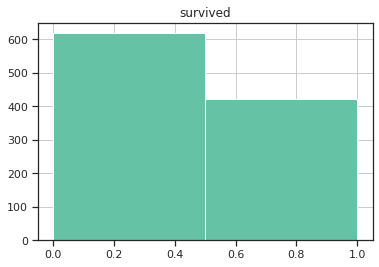

In [4]:
#What is the "base rate" of survival?
df.hist("survived", bins=2)
plt.title("survived")
plt.show
df["survived"].value_counts()/df["survived"].count()

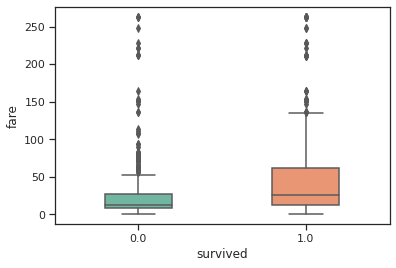

In [5]:
sns.boxplot(x="survived", y="fare", width=0.4, data=df)
plt.show()

Above we see boxplots that show the fare distribution grouped by our target variable (survival). The left boxplot corresponds to people that died and the right one to people that survived. Alternatively, let's plot the distribution of fare according to survival:

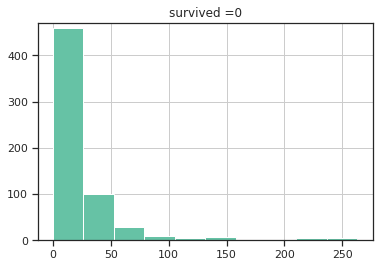

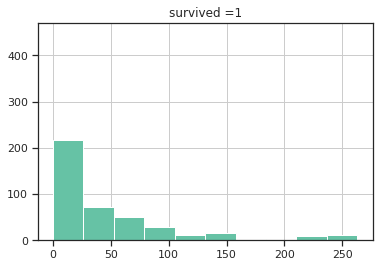

In [6]:
for r in range(2):
    hist = df[df.survived == r].hist('fare')
    plt.title("survived =" + str(r))
    plt.ylim(0,470)
    plt.show()

It seems that people that paid less are less likely to survive. We could use this to predict that people that paid more than 50 will survive. How effective is this threshold? Let's quantify it!

***


**Entropy** ($H$) and **information gain** ($IG$) au useful tools for measuring the effectiveness of a split on the data. Entropy measures how random data is, information gain is a measure of the reduction in randomness after performing a split.

<table style="border: 0px">
<tr style="border: 0px">
<td style="border: 0px"><img src="https://github.com/pearl-yu/foster_2022fall/blob/2022-master/Module2_Supervised/images/dsfb_0304.png?raw=1" height=80% width=80%>
Figure 3-4. Splitting the "write-off" sample into two segments, based on splitting the Balance attribute (account balance) at 50K.</td>
<td style="border: 0px; width: 30px"></td>
<td style="border: 0px"><img src="https://github.com/pearl-yu/foster_2022fall/blob/2022-master/Module2_Supervised/images/dsfb_0305.png?raw=1" height=75% width=75%>
Figure 3-5. A classification tree split on the three-values Residence attribute.</td>
</tr>
</table>

Given the data, it is fairly straight forward to calculate both of these quantities.

##### Functions to get the entropy and IG

In [ ]:
def entropy(target_column):
    """
        computes -sum_i p_i * log_2 (p_i) for each i
    """
    # get the counts of each target value
    target_counts = target_column.value_counts().astype(float).values
    total = target_column.count()  
    # compute probas
    probas = target_counts/total
    # p_i * log_2 (p_i)
    entropy_components = probas * np.log2(probas)
    # return negative sum
    return - entropy_components.sum()

def information_gain(df, info_column, target_column, threshold):
    """
        computes H(target) - H(target | info > thresh) - H(target | info <= thresh)
    """
    # split data
    data_above_thresh = df[df[info_column] > threshold]
    data_below_thresh = df[df[info_column] <= threshold]
    # get entropy
    H = entropy(df[target_column])
    entropy_above = entropy(data_above_thresh[target_column])
    entropy_below = entropy(data_below_thresh[target_column])
    # compute weighted average
    ct_above = data_above_thresh.shape[0]
    ct_below = data_below_thresh.shape[0]
    tot = float(df.shape[0])
    return H - entropy_above*ct_above/tot - entropy_below*ct_below/tot 

Now that we have a way of calculating $H$ and $IG$, let's test our prior hunch, that using 50 as a split on fare allows us to determine if someone will survive.

In [ ]:
threshold = 50
prior_entropy = entropy(df["survived"])
IG = information_gain(df, "fare", "survived", threshold)
print ("IG of %.4f using a threshold of %.2f given a prior entropy of %.4f" % (IG, threshold, prior_entropy))

How good was our guess of 50? Let's loop through all possible splits on fare and see what is the best!

In [ ]:
def best_threshold(df, info_column, target_column, criteria=information_gain):
    maximum_ig = 0
    maximum_threshold = 0

    for thresh in df[info_column].unique():
        IG = criteria(df, info_column, target_column, thresh)
        if IG > maximum_ig:
            maximum_ig = IG
            maximum_threshold = thresh
            
    return (maximum_threshold, maximum_ig)

maximum_threshold, maximum_ig = best_threshold(df, "fare", "survived")

print ("the maximum IG we can achieve splitting on %s is %.4f using a thresh of %.2f" % ('fare', maximum_ig, maximum_threshold))

Other observed features may also give us a strong clue about survival.

In [ ]:
# Names of different columns
categorical_cols = ["pclass", "female"]
continuous_cols = ["age", "fare"]
target_col = "survived"
predictor_cols = categorical_cols + continuous_cols

# This is to plot everything in a 2x2 space
rows, cols = 2, 2
fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(7*cols, 7*rows))
axs = axs.flatten()
posn = 0

# Plot continous features
for col in continuous_cols:
    sns.boxplot(target_col, col, data=df, ax=axs[posn])
    axs[posn].set_ylabel(col)
    axs[posn].set_title("")
    posn += 1

# Plot categorical features
for col in categorical_cols:
    df.groupby(col)[target_col].mean().plot(kind="bar", ax=axs[posn])
    axs[posn].set_ylabel("Fraction that survived")
    posn += 1
    
plt.tight_layout()

This now begs the question: what feature gives the most effective split? 

In [ ]:
def best_split(df, info_columns, target_column, criteria=information_gain):
    maximum_ig = 0
    maximum_threshold = 0
    maximum_column = ""
    
    for info_column in info_columns:
        thresh, ig = best_threshold(df, info_column, target_column, criteria)
        
        if ig > maximum_ig:
            maximum_ig = ig
            maximum_threshold = thresh
            maximum_column = info_column

    return maximum_column, maximum_threshold, maximum_ig

max_col, max_threshold, max_ig = best_split(df, predictor_cols, "survived")

print ("The best column to split on is %s giving us a IG of %.4f using a thresh of %.2f" % (max_col, max_ig, max_threshold))

### The Classification Tree: Recursive Splitting

Of course, splitting the data one time sometimes isn't enough to make accurate categorical predictions. However, we can continue to split the data recursively, building a tree-structured model that may give better results. This recursive splitting is the basis for a "decision tree classifier" or "classification tree", a popular and powerful class of machine learning algorithm.  

What are some other ways you might consider splitting the data?

In [ ]:
import matplotlib.patches as mpatches

cmap = {1: 'blue', 0: 'red'}
df.plot(kind="scatter", x="fare", y="age", c=[cmap[c] for c in df[target_col]])
plt.legend(handles=[mpatches.Patch(color=cmap[k], label=k) for k in cmap], loc=1, title="Target", frameon=True)
plt.show()

Rather than build a classification tree from scratch (think if you could now do this!) let's use sklearn's implementation which includes some additional functionality. 

In [ ]:
from sklearn.tree import DecisionTreeClassifier
# Let's define the model (tree)
# ---> This is really both defining the model AND the ML algorithm to learn (train) it!
decision_tree = DecisionTreeClassifier(max_depth=3, criterion="entropy")   # Look at those 2 arguments !!! 
# Let's tell the model what is the "training" data and then train it
decision_tree.fit(df[predictor_cols], df["survived"])

We now have a classification tree, let's visualize the results!

In [ ]:
from IPython.display import Image
from sklearn.tree import export_graphviz

def visualize_tree(decision_tree, feature_names, class_names, directory="./images", name="tree",proportion=True):
    # Export our decision tree to graphviz format
    dot_name = "%s/%s.dot" % (directory, name)
    dot_file = export_graphviz(decision_tree, out_file=dot_name,
                               feature_names=feature_names, class_names=class_names,proportion=proportion)
    # Call graphviz to make an image file from our decision tree
    image_name = "%s/%s.png" % (directory, name)
    os.system("dot -T png %s -o %s" % (dot_name, image_name))
    # Return the .png image so we can see it
    return Image(filename=image_name)

visualize_tree(decision_tree, predictor_cols, ["dies", "survives"])

Let's look at `"age"` and `"fare"`, including the **DECISION SURFACE!!**

More details for this graph: [sklearn decision surface](https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html#sphx-glr-auto-examples-tree-plot-iris-dtc-py)

In [ ]:
def Decision_Surface(data, col1, col2, target, model, probabilities=False):
    # Get bounds
    x_min, x_max = data[col1].min(), data[col1].max()
    y_min, y_max = data[col2].min(), data[col2].max()
    # Create a mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.5), np.arange(y_min, y_max,0.5))
    meshed_data = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()])
    # Get predictions for the mesh
    tdf = data[[col1, col2]]
    model.fit(tdf, target)
    if probabilities:
        Z = model.predict_proba(meshed_data)[:, 1].reshape(xx.shape)
    else:
        Z = model.predict(meshed_data).reshape(xx.shape)                
    # Chart details
    plt.figure(figsize=[12,7])
    plt.title("Decision surface")    
    plt.xlabel(col1)
    plt.ylabel(col2)
    if probabilities:
        # Color-scale on the contour (surface = separator)
        cs = plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm_r, alpha=0.4)
    else:
        # Only a curve/line on the contour (surface = separator)
        cs = plt.contourf(xx, yy, Z, levels=[-1,0,1], cmap=plt.cm.coolwarm_r, alpha=0.4)
    # Plot scatter plot    
    cmap = {1: 'blue', 0: 'red'}
    colors = [cmap[c] for c in df[target_col]]
    plt.scatter(data[col1], data[col2], color=colors)
    # Build legend
    plt.legend(handles=[mpatches.Patch(color=cmap[k], label=k) for k in cmap], loc="best", title="Target", frameon=True)
    plt.show() 
    
tree_depth=1
model = DecisionTreeClassifier(max_depth=tree_depth, criterion="entropy")
Decision_Surface(df, "fare", "age", df.survived, model)
#visualize_tree(model, ["fare","age"], ["dies", "survives"])


How good is our model? Let's compute accuracy, the percent of times where we correctly identified whether a passenger survives.

In [ ]:
from sklearn import metrics
print ( "Accuracy = %.3f" % (metrics.accuracy_score(decision_tree.predict(df[predictor_cols]), df["survived"])) )

What are some other ways we could classify the data? The other bread-and-butter machine learning method is linear modeling; let's take a look to see how that partitions the data.

In [ ]:
from sklearn import linear_model
import warnings
warnings.filterwarnings('ignore')

lin_model = linear_model.LogisticRegression()
Decision_Surface(df, "fare", "age", df.survived, lin_model, False)

And this is the accuracy:

In [ ]:
from sklearn import metrics
lin_model.fit(df[predictor_cols], df.survived)
print ("Accuracy = %.3f" % (metrics.accuracy_score(lin_model.predict(df[predictor_cols]), df.survived)) )